In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import multiprocessing
import pickle
from numpy import asarray
import gensim.downloader as api
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.utils import pad_sequences

import re
import emoji
import nltk
import numpy as np
from nltk.tokenize.casual import EMOTICON_RE
#nltk.download('wordnet')
#nltk.download('words')
from nltk.sentiment.util import mark_negation
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker #TODO

from nltk import FreqDist

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, RocCurveDisplay, confusion_matrix, classification_report
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

In [5]:
# DATASET
DATASET_COLUMNS = ['Id', 'Review', 'Sentiment']
# Define a dictionary to map sentiment values to category names
sentiment_labels = {1: 'Negative', 2: 'Neutral', 3: 'Positive'}
NUM_of_CLASSES = 3

Goal of project: 

This notebook includes: (steps)

### Load Dataset

First, we load and explore the dataset and apply some initial processing such as setting the '*Id*' column as index and removing any empty rows.

In [6]:
def drop_missing(data):
    # Remove any rows with missing values and reset the index
    data.replace('', np.nan, inplace=True)
    data = data.dropna()
    data.reset_index(drop=True, inplace=True)
    return data

In [7]:
# Load dataset
input_folder_path = "./pls/Thesis_Jupyter_Final/input/"
data_filename = "reviews_data.csv"
data_file_path = os.path.join(input_folder_path, data_filename)

df_raw = pd.read_csv(data_file_path)
df_raw = df_raw[:10000]

# Set ID as index
df_raw.set_index('Id', inplace=True, drop=True)

# Remove NaN rows, before cleaning text
df_raw = drop_missing(df_raw)

# Create a copy of the original DataFrame to preserve the original data
df = df_raw.copy()

print(df_raw.info())
print(f'\nDataset shape: {df_raw.shape}\n')
df_raw.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     10000 non-null  object
 1   Sentiment  10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB
None

Dataset shape: (10000, 2)



Review  Sentiment
0                               good and interesting          3
1  This class is very helpful to me. Currently, I...          3
2  like!Prof and TAs are helpful and the discussi...          3
3  Easy to follow and includes a lot basic and im...          3
4  Really nice teacher!I could got the point eazl...          3
5  Great course - I recommend it for all, especia...          3
6    One of the most useful course on IT Management!          3
7  I was disappointed because the name is mislead...          2
8    Super content. I'll definitely re-do the course          3
9  One of the excellent courses at Coursera for i...          3

### Analysing Data (TODO)
We then analyse the dataset by observing the distribution of review per sentiment.

3 (Positive): 8917 reviews
1 (Negative): 588 reviews
2 (Neutral): 495 reviews


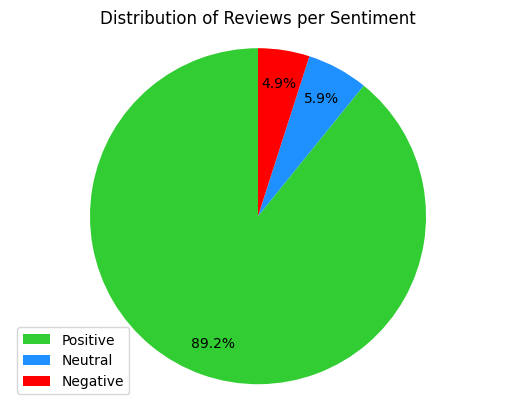

In [8]:
# Count the number of reviews per sentiment
sentiment_counts = df['Sentiment'].value_counts()

# Print the counts for each category
for sentiment_value, count in sentiment_counts.items():
    sentiment_name = sentiment_labels[sentiment_value]
    print(f"{sentiment_value} ({sentiment_name}): {count} reviews")

# Define labels and colors for the pie chart
labels = ['Positive', 'Neutral', 'Negative']
colors = ['limegreen', 'dodgerblue', 'red']

# Plot the pie chart
plt.pie(sentiment_counts, colors=colors, autopct='%1.1f%%',  pctdistance=0.8, textprops={'fontsize': 10, 'color': 'black'}, startangle=90)
plt.axis('equal')  # pie as a circle
plt.legend(labels=labels, loc='lower left')
plt.title('Distribution of Reviews per Sentiment')
plt.show()

## Clean Text

Next, we clean the data applying the following techniques (TODO: add info):

In [10]:
# Text Cleaning
#english_words = set(nltk.corpus.words.words())
emojis = [
        #HAPPY
        ":-)",
        ":)",
        ";)",
        ":o)",
        ":]",
        ":3",
        ":c)",
        ":>",
        "=]",
        "8)",
        "=)",
        ":}",
        ":^)",
        ":-D",
        ":D",
        "8-D",
        "8D",
        "x-D",
        "xD",
        "X-D",
        "XD",
        "=-D",
        "=D",
        "=-3",
        "=3",
        ":-))",
        ":'-)",
        ":')",
        ":*",
        ":^*",
        ">:P",
        ":-P",
        ":P",
        "X-P",
        "x-p",
        "xp",
        "XP",
        ":-p",
        ":p",
        "=p",
        ":-b",
        ":b",
        ">:)",
        ">;)",
        ">:-)",
        "<3",
        # SAD
        ":L",
        ":-/",
        ">:/",
        ":S",
        ">:[",
        ":@",
        ":-(",
        ":[",
        ":-||",
        "=L",
        ":<",
        ":-[",
        ":-<",
        "=\\",
        "=/",
        ">:(",
        ":(",
        ">.<",
        ":'-(",
        ":'(",
        ":\\",
        ":-c",
        ":c",
        ":{",
        ">:\\",
        ";(",
    ]

In [11]:
# 1) Lowercase
df['Review'] = df['Review'].str.lower()
pd.set_option('display.max_rows', df.shape[0]+1)
print(df)

In [ ]:
# 2) Replace contractions with their standard full forms
contraction_mapping = {
        "isn't": "is not",
        "aren't": "are not",
        "don't": "do not",
        "doesn't": "does not",
        "wasn't": "was not",
        "weren't": "were not",
        "didn't": "did not",
        "haven't": "have not",
        "hasn't": "has not",
        "hadn't": "had not",
        "won't": "will not",
        "can't": "cannot",
        "couldn't": "could not",
        "shouldn't": "should not",
        "wouldn't": "would not",
        "mightn't": "might not",
        "mustn't": "must not",
        }

for contraction, standard in contraction_mapping.items():
    df['Review'] = df['Review'].str.replace(contraction, standard)

print(df)

                                                 Review  Sentiment
0                                  good and interesting          3
1     this class is very helpful to me. currently, i...          3
2     like!prof and tas are helpful and the discussi...          3
3     easy to follow and includes a lot basic and im...          3
4     really nice teacher!i could got the point eazl...          3
5     great course - i recommend it for all, especia...          3
6       one of the most useful course on it management!          3
7     i was disappointed because the name is mislead...          2
8       super content. i'll definitely re-do the course          3
9     one of the excellent courses at coursera for i...          3
10    is there any reason why you should not apply t...          3
11     excellent course and teachers. congratulations!!          3
12    this is a good course for an cio in a non tech...          3
13    good content, but the course setting does (at ...       

In [ ]:
# 3) Remove punctuation in between words e.g. "course.sometimes", "i'll" and replace with space
pattern = r'(?<=\w)[^\w\s]+(?=\w)'
df['Review'] = df['Review'].str.replace(pattern, ' ')
print(df)

                                                 Review  Sentiment
0                                  good and interesting          3
1     this class is very helpful to me. currently, i...          3
2     like prof and tas are helpful and the discussi...          3
3     easy to follow and includes a lot basic and im...          3
4     really nice teacher i could got the point eazl...          3
5     great course - i recommend it for all, especia...          3
6       one of the most useful course on it management!          3
7     i was disappointed because the name is mislead...          2
8       super content. i ll definitely re do the course          3
9     one of the excellent courses at coursera for i...          3
10    is there any reason why you should not apply t...          3
11     excellent course and teachers. congratulations!!          3
12    this is a good course for an cio in a non tech...          3
13    good content, but the course setting does (at ...       

/tmp/ipykernel_4049092/1580789109.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Review'] = df['Review'].str.replace(pattern, ' ')


In [ ]:
# 4) Tokenize text into individual words (removes all extra spaces \s)
tokenizer = TweetTokenizer()
df['Review'] = df['Review'].apply(tokenizer.tokenize)
df.head()

Review  Sentiment
0                           [good, and, interesting]          3
1  [this, class, is, very, helpful, to, me, ., cu...          3
2  [like, prof, and, tas, are, helpful, and, the,...          3
3  [easy, to, follow, and, includes, a, lot, basi...          3
4  [really, nice, teacher, i, could, got, the, po...          3

In [ ]:
# 5) Remove punctuation first in between words (typo), and then all punctuation and numerals except for tokenized emojis
pattern = r"[^\w\s" + "".join(re.escape(e) for e in emojis + list(emoji.EMOJI_DATA.keys())) + "]|[\d]+" # match non-emoji special characters
df['Review'] = df['Review'].apply(lambda tokens: [token for token in tokens if not re.match(pattern, token)])
print(df)

                                                 Review  Sentiment
0                              [good, and, interesting]          3
1     [this, class, is, very, helpful, to, me, ., cu...          3
2     [like, prof, and, tas, are, helpful, and, the,...          3
3     [easy, to, follow, and, includes, a, lot, basi...          3
4     [really, nice, teacher, i, could, got, the, po...          3
5     [great, course, -, i, recommend, it, for, all,...          3
6     [one, of, the, most, useful, course, on, it, m...          3
7     [i, was, disappointed, because, the, name, is,...          2
8     [super, content, ., i, ll, definitely, re, do,...          3
9     [one, of, the, excellent, courses, at, courser...          3
10    [is, there, any, reason, why, you, should, not...          3
11    [excellent, course, and, teachers, ., congratu...          3
12    [this, is, a, good, course, for, an, cio, in, ...          3
13    [good, content, but, the, course, setting, doe...       

In [ ]:
# 6) Remove single characters
df['Review'] = df['Review'].apply(lambda tokens: [word for word in tokens if len(word) > 1])
print(df)

                                                 Review  Sentiment
0                              [good, and, interesting]          3
1     [this, class, is, very, helpful, to, me, curre...          3
2     [like, prof, and, tas, are, helpful, and, the,...          3
3     [easy, to, follow, and, includes, lot, basic, ...          3
4     [really, nice, teacher, could, got, the, point...          3
5     [great, course, recommend, it, for, all, espec...          3
6     [one, of, the, most, useful, course, on, it, m...          3
7     [was, disappointed, because, the, name, is, mi...          2
8     [super, content, ll, definitely, re, do, the, ...          3
9     [one, of, the, excellent, courses, at, courser...          3
10    [is, there, any, reason, why, you, should, not...          3
11    [excellent, course, and, teachers, congratulat...          3
12    [this, is, good, course, for, an, cio, in, non...          3
13    [good, content, but, the, course, setting, doe...       

In [ ]:
# 7) Correct Spelling
# Note: also removes '...' that was not removed before
def correct_spelling(tokens):
    corrected_tokens = []
    for token in tokens:
        if token in emojis or token in emoji.EMOJI_DATA.keys():
            corrected_tokens.append(token)  # If token is an emoji, add it to the corrected tokens
        else:
            corrected_token = spell_checker.correction(token)
            if corrected_token is not None:
                corrected_tokens.append(corrected_token)
                
    return corrected_tokens

In [ ]:
spell_checker = SpellChecker()
df['Review'] = df['Review'].apply(correct_spelling)
print(df)

                                                 Review  Sentiment
0                              [good, and, interesting]          3
1     [this, class, is, very, helpful, to, me, curre...          3
2     [like, prof, and, tas, are, helpful, and, the,...          3
3     [easy, to, follow, and, includes, lot, basic, ...          3
4     [really, nice, teacher, could, got, the, point...          3
5     [great, course, recommend, it, for, all, espec...          3
6     [one, of, the, most, useful, course, on, it, m...          3
7     [was, disappointed, because, the, name, is, mi...          2
8     [super, content, all, definitely, re, do, the,...          3
9     [one, of, the, excellent, courses, at, course,...          3
10    [is, there, any, reason, why, you, should, not...          3
11    [excellent, course, and, teachers, congratulat...          3
12    [this, is, good, course, for, an, ceo, in, non...          3
13    [good, content, but, the, course, setting, doe...       

In [ ]:
# TODO: note to self (to be added to word-doc): If you check token by token, it also removes english words

In [ ]:
# 8) Perform negation tagging
df['Review'] = df['Review'].apply(mark_negation)
print(df)

                                                 Review  Sentiment
0                              [good, and, interesting]          3
1     [this, class, is, very, helpful, to, me, curre...          3
2     [like, prof, and, tas, are, helpful, and, the,...          3
3     [easy, to, follow, and, includes, lot, basic, ...          3
4     [really, nice, teacher, could, got, the, point...          3
5     [great, course, recommend, it, for, all, espec...          3
6     [one, of, the, most, useful, course, on, it, m...          3
7     [was, disappointed, because, the, name, is, mi...          2
8     [super, content, all, definitely, re, do, the,...          3
9     [one, of, the, excellent, courses, at, course,...          3
10    [is, there, any, reason, why, you, should, not...          3
11    [excellent, course, and, teachers, congratulat...          3
12    [this, is, good, course, for, an, ceo, in, non...          3
13    [good, content, but, the, course, setting, doe...       

In [ ]:
# 9) Remove stopwords --> also removes words like 'not'
stop_words = set(stopwords.words('english'))
df['Review'] = df['Review'].apply(lambda tokens: [token for token in tokens if token not in stop_words])
df['Review'] = df['Review'].apply(lambda tokens: [token for token in tokens if token.split('_')[0] not in stop_words])
print(df)

                                                 Review  Sentiment
0                                   [good, interesting]          3
1     [class, helpful, currently, still, learning, c...          3
2     [like, prof, tas, helpful, discussion, among, ...          3
3     [easy, follow, includes, lot, basic, important...          3
4     [really, nice, teacher, could, got, point, early]          3
5     [great, course, recommend, especially, busines...          3
6                     [one, useful, course, management]          3
7     [disappointed, name, misleading, course, provi...          2
8                  [super, content, definitely, course]          3
9     [one, excellent, courses, course, information,...          3
10    [reason, apply_NEG, course_NEG, big_NEG, conte...          3
11       [excellent, course, teachers, congratulations]          3
12         [good, course, ceo, non, technical, company]          3
13    [good, content, course, setting, least, allow_...       

In [ ]:
# 10) Lemmatize words using WordNetLemmatizer (also lemmatizes words removing _NEG)
def lemmatize_token(token):
    lemmatizer = WordNetLemmatizer()
    if "_NEG" in token:
        word, tag = token.split("_NEG")
        return lemmatizer.lemmatize(word) + "_NEG"
    else:
        return lemmatizer.lemmatize(token)

In [ ]:
df['Review'] = df['Review'].apply(lambda tokens: [lemmatize_token(token) for token in tokens])
print(df)

                                                 Review  Sentiment
0                                   [good, interesting]          3
1     [class, helpful, currently, still, learning, c...          3
2     [like, prof, ta, helpful, discussion, among, s...          3
3     [easy, follow, includes, lot, basic, important...          3
4     [really, nice, teacher, could, got, point, early]          3
5     [great, course, recommend, especially, busines...          3
6                     [one, useful, course, management]          3
7     [disappointed, name, misleading, course, provi...          2
8                  [super, content, definitely, course]          3
9     [one, excellent, course, course, information, ...          3
10    [reason, apply_NEG, course_NEG, big_NEG, conte...          3
11         [excellent, course, teacher, congratulation]          3
12         [good, course, ceo, non, technical, company]          3
13    [good, content, course, setting, least, allow_...       

In [ ]:
# Convert preprocessed tokens back to string
df['Review'] = df['Review'].apply(' '.join)
df.head()

Review  Sentiment
0                                   good interesting          3
1  class helpful currently still learning class m...          3
2  like prof ta helpful discussion among student ...          3
3  easy follow includes lot basic important techn...          3
4          really nice teacher could got point early          3

In [ ]:
print(f'Shape before: {df_raw.shape}')
print(f'Shape after preprocessing, before removing empty rows: {df.shape}')

# Remove NaN rows, after cleaning text
df = drop_missing(df) 
print(f'Shape after preprocessing, after removing empty rows: {df.shape}\n')

Shape before: (10000, 2)
Shape after preprocessing, before removing empty rows: (10000, 2)
Shape after preprocessing, after removing empty rows: (9995, 2)



In [ ]:
cleaned_data_filename = "cleaned_data.csv"
data_file_path = os.path.join(input_folder_path, cleaned_data_filename)
df.to_csv(data_file_path, sep=',', index_label='Id')

# EDA Functions

In [119]:
def make_wordcloud(word_counts):
    wordcloud = WordCloud().generate_from_frequencies(word_counts)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [129]:
def plot_word_freq_most_common(dataset, num_most_common=60):
    all_words = [word for review in dataset for word in review.split()]

    fdist = FreqDist(all_words)
    plt.figure(figsize=(10, 5))
    fdist.plot(num_most_common, title=f'Frequency Distribution of Most Common {num_most_common} Tokens')
    plt.show()

In [145]:

def plot_word_freq_cdf(word_counts, max_count):
    frequencies = list(word_counts.values())
    sorted_counts = np.sort(frequencies) # ascending

    # Calculate the cumulative sum of the sorted frequencies & normalize
    cumu_counts = np.cumsum(sorted_counts)
    cdf = cumu_counts / cumu_counts[-1]

    # Plot the CDF
    plt.plot(sorted_counts, cdf)
    plt.xlabel('Word Frequency')
    plt.ylabel('CDF')
    plt.title('CDF of Word Frequencies')
    x_ticks = np.arange(0, max_count, 500)
    plt.xticks(x_ticks)
    plt.grid(True)
    plt.show()

In [132]:
def plot_word_freq_hist(word_counts):
    # Set up a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot word frequency distribution with linear scale
    ax1.hist(word_counts.values(), bins=range(1, 50), alpha=0.5)
    ax1.set_title('Word Frequency Distribution (Linear Scale)')
    ax1.set_xlabel('Word Frequency')
    ax1.set_ylabel('Number of Words')

    # Plot word frequency distribution with logarithmic scale
    ax2.hist(word_counts.values(), bins=range(1, 500, 10), alpha=0.5)
    ax2.set_yscale('log')
    ax2.set_title('Word Frequency Distribution (Logarithmic Scale)')
    ax2.set_xlabel('Word Frequency')
    ax2.set_ylabel('Number of Words')

In [165]:
def calculate_word_statistics(word_counts):
    freqs = np.array(list(word_counts.values()))

    print("Mean frequency: ", np.mean(freqs))
    print("Median frequency: ", np.median(freqs))
    print("Max frequency: ", max(freqs))
    print("Min frequency: ", min(freqs))
    print("Standard deviation: ", np.std(freqs))
    print("1st quartile: ", np.percentile(freqs, 25))
    print("3rd quartile: ", np.percentile(freqs, 75))

# Preprocess Data

First we load cleaned data.

In [123]:
input_folder_path = "./pls/Thesis_Jupyter_Final/input/"
cleaned_data_filename = "cleaned_data.csv"
data_file_path = os.path.join(input_folder_path, cleaned_data_filename)
df = pd.read_csv(data_file_path)

### Split train and test

In [124]:
# Split dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(df['Review'], df['Sentiment'],
                                                    test_size=0.2, random_state=42)
# Split the training dataset further into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print("Data Distribution:\n* train: {}\n* validation: {}\n* test: {}\n".format(len(x_train), len(x_val), len(x_test)))
print(f"x_train: {x_train.head()}")

Data Distribution:
* train: 6396
* validation: 1600
* test: 1999

x_train: 4758                       really cool stuff profanes :-)
7310    course wonderful video long_NEG full_NEG infor...
5344                   really good course would recommend
9460    one best online offline course taken love enth...
4142    great loved fact could watch video follow step...
Name: Review, dtype: object


### Create vocabulary

In [126]:
# Count words to create vocabulary
word_freqs = Counter()
for review in x_train:
    word_freqs.update(review.split())

word_freqs_len = len(word_freqs)

print(f"50 Most common words: {word_freqs.most_common(50)}")
print(f"Unfiltered vocab size: {word_freqs_len}")

50 Most common words: [('course', 4682), ('great', 1381), ('good', 1155), ('course_NEG', 744), ('really', 679), ('lot', 608), ('excellent', 567), ('well', 555), ('interesting', 553), ('thank', 408), ('much', 400), ('useful', 391), ('learn', 355), ('would', 350), ('easy', 338), ('material', 334), ('way', 333), ('thanks', 329), ('lecture', 320), ('professor', 314), ('time', 314), ('understand', 312), ('content', 307), ('one', 306), ('teacher', 304), ('information', 303), ('like', 302), ('data', 294), ('video', 292), ('class', 285), ('learning', 282), ('best', 279), ('introduction', 270), ('basic', 266), ('learned', 258), ('recommend', 252), ('clear', 250), ('enjoyed', 246), ('informative', 245), ('knowledge', 244), ('concept', 236), ('instructor', 234), ('assignment', 231), ('also', 230), ('helpful', 223), ('nice', 222), ('work', 214), ('week', 208), ('amazing', 205), ('love', 200)]
Unfiltered vocab size: 9072


In [166]:
calculate_word_statistics(word_freqs)

Mean frequency:  9.326168430335096
Median frequency:  2.0
Max frequency:  4682
Min frequency:  1
Standard deviation:  60.41300195746837
1st quartile:  1.0
3rd quartile:  5.0


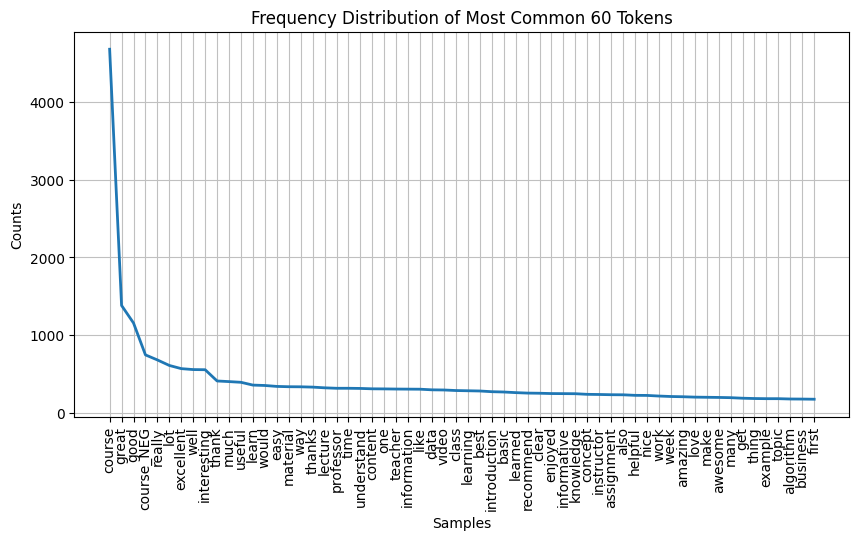

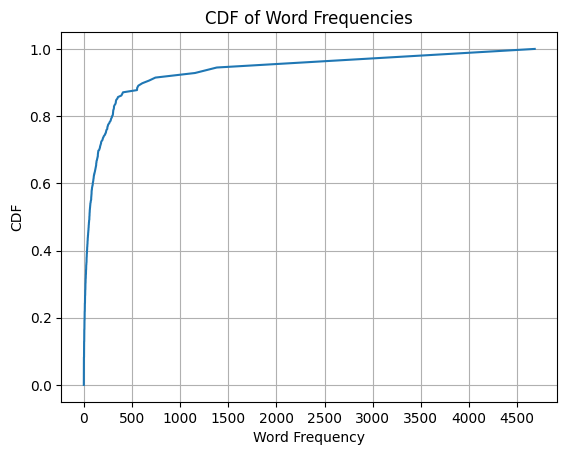

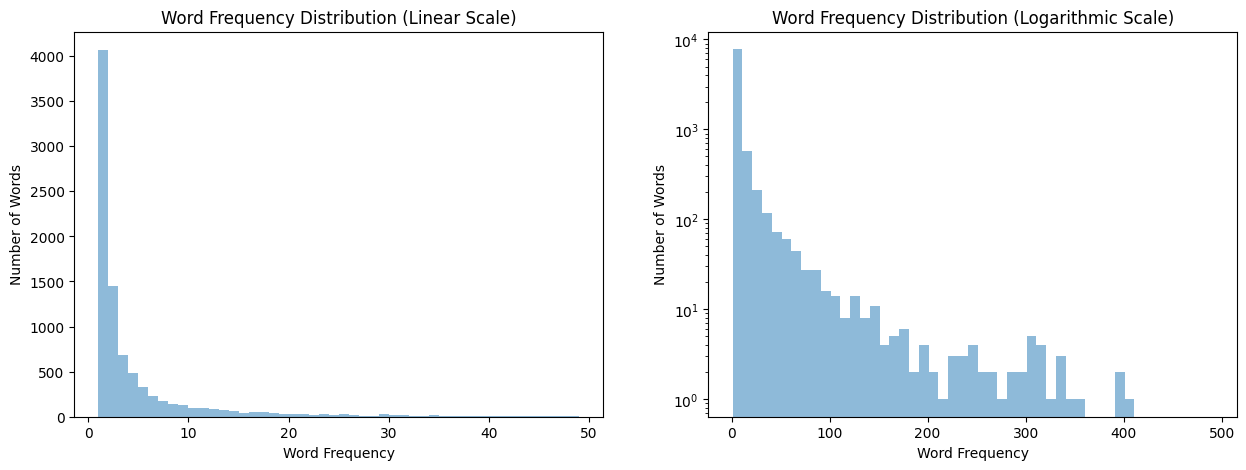

In [162]:
#make_wordcloud(word_freqs)
plot_word_freq_most_common(x_train, 60) # Zipf's law plot, large number of words have very low frequencies
plot_word_freq_cdf(word_freqs, max(word_freqs.values()))
plot_word_freq_hist(word_freqs)

Around 90% of the words in the vocabulary occur 700 times or less.

In [171]:
# PROCESSING-CONSTANTS
MIN_WORD_FREQ = 2
MAX_WORD_FREQ = 700
EMBEDDING_DIM = 100

In [174]:
# Filter vocabulary by removing words with frequency less than a set minimum frequency
vocab = [word for word, count in word_freqs.items() if (count >= MIN_WORD_FREQ) and (count <= MAX_WORD_FREQ)]
vocab_size = len(vocab)
print("Vocabulary size of {} reduced to {}.\n".format(word_freqs_len, vocab_size))
print("Vocabulary (first 50 tokens):\n{}".format(vocab[:50]))

Vocabulary size of 9072 reduced to 5001.

Vocabulary (first 50 tokens):
['really', 'cool', 'stuff', ':-)', 'wonderful', 'video', 'long_NEG', 'full_NEG', 'information_NEG', 'choose_NEG', 'healthier_NEG', 'lifestyle_NEG', 'thank_NEG', 'much_NEG', 'use_NEG', 'knowledge_NEG', 'improve_NEG', 'family_NEG', 'health_NEG', 'would', 'recommend', 'one', 'best', 'online', 'offline', 'taken', 'love', 'enthusiasm', 'professor', 'focus', 'understanding', 'actual', 'dynamic', 'behind', 'formula', 'loved', 'fact', 'could', 'watch', 'follow', 'step', 'pace', 'content', 'objective', 'clear', 'text', 'supportive', 'subject', 'presented', 'open']


In [179]:
processed_folder_path = "./pls/Thesis_Jupyter_Final/processed"
# Create the folder if it doesn't exist
if not os.path.exists(processed_folder_path):
    os.makedirs(processed_folder_path)

vocab_filename = 'vocab.txt'
file_path = os.path.join(processed_folder_path, vocab_filename)
with open(file_path, 'w') as file:
    file.write('\n'.join(vocab))

### Filter data with vocabulary

In [180]:
def freq_filter_dataset(docs, filename, vocab):
    filtered_dataset = []
    for doc in docs:
        filtered_text = ' '.join([word for word in doc.split() if word in vocab])
        filtered_dataset.append(filtered_text)

    # Save filtered dataset to a txt file
    filtered_filename = f'filtered_{str(filename)}.txt'
    file_path = os.path.join(processed_folder_path, filtered_filename)
    with open(file_path, 'w') as file:
        file.write('\n'.join(filtered_dataset))

    # Convert the processed documents back to pandas.Series
    filtered_dataset = pd.Series(filtered_dataset, index=docs.index)

    # Convert empty rows to '<empty>'
    placeholder = "<empty>"
    filtered_dataset.replace('', placeholder, inplace=True)
    
    # Count the number of rows with '<empty>' #TODO: remove empty rows
    num_empty_rows = filtered_dataset.str.count('<empty>').sum()
    print(f'Number of rows with <empty> for {filename}: {num_empty_rows}')

    # TODO: instead of saving, print?
    # Save filled dataset to a txt file
    filled_filename = f'filled_{str(filename)}.txt'
    file_path = os.path.join(processed_folder_path, filled_filename)
    with open(file_path, 'w') as file:
        file.write('\n'.join(filtered_dataset))
    
    return filtered_dataset

In [181]:
# Filter dataset based on vocabulary
x_train = freq_filter_dataset(x_train, "x_train", vocab)
x_val = freq_filter_dataset(x_val, "x_val", vocab)
x_test = freq_filter_dataset(x_test, "x_test", vocab)

print("\nData Distribution:\n* train: {}\n* validation: {}\n* test: {}\n".format(len(x_train), len(x_val), len(x_test)))
print(f"x_train - updated: {x_train.head()}")

Number of rows with <empty> for x_train: 191
Number of rows with <empty> for x_val: 46
Number of rows with <empty> for x_test: 57

Data Distribution:
* train: 6396
* validation: 1600
* test: 1999

x_train - updated: 4758                                really cool stuff :-)
7310    wonderful video long_NEG full_NEG information_...
5344                               really would recommend
9460    one best online offline taken love enthusiasm ...
4142    loved fact could watch video follow step pace ...
dtype: object


## TF-IDF

In [182]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [183]:
# PARAMS 

# TF-IDF
MAX_FEATURES = 10000
MAX_DF = 0.95
MIN_DF = 5

In [184]:
# Initialize TfidfVectorizer with the filtered vocabulary
tfidf_vectorizer = TfidfVectorizer(
    max_features=MAX_FEATURES, # maximum number of features to keep, check unique vocabs and determine based on that, high causes saprse metrics and low value causes loss in important words/vocab
    vocabulary=vocab,
    lowercase=False,
    ngram_range=(1, 1),  # range of n-grams, only unigrams now
    max_df=MAX_DF,  # ignore terms that have a document frequency strictly higher than the threshold
    min_df=MIN_DF,  # ignore terms that have a document frequency strictly lower than the threshold.
    use_idf=True,  # enable IDF weighting
    smooth_idf=True,  # smooth IDF weights --> provides stability, reduces run time errors
    sublinear_tf=True  # apply sublinear scaling to term frequencies
)

# Fit and transform the training set
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)

# Transform the validation and testing set
x_val_tfidf = tfidf_vectorizer.transform(x_val)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

In [185]:
def save_tfidf_data(data, data_name, feature_names):
    # Save the matrix with feature names as a DataFrame
    data = pd.DataFrame(data.toarray(), columns=feature_names)
    tfidf_filename = f'{data_name}.csv'
    file_path = os.path.join(processed_folder_path, tfidf_filename)
    data.to_csv(file_path, index=False)

In [186]:
# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Save vectorized data
save_tfidf_data(x_train_tfidf, "train_tfidf", feature_names)
save_tfidf_data(x_train_tfidf, "val_tfidf", feature_names)
save_tfidf_data(x_test_tfidf, "test_tfidf", feature_names)

In [187]:
print("Given vocabulary-size : {},".format(vocab_size))
print("\nData Shape:\n* train: {}\n* validation: {}\n* test: {}\n".format(x_train_tfidf.shape, x_val_tfidf.shape, x_test_tfidf.shape))
print("x_train_tfidf:\n{}".format(x_train_tfidf))

Given vocabulary-size : 5001,

Data Shape:
* train: (6396, 5001)
* validation: (1600, 5001)
* test: (1999, 5001)

x_train_tfidf:
  (0, 2)	0.6285824493041854
  (0, 1)	0.6915158871384078
  (0, 0)	0.35593522200244804
  (1, 18)	0.2827904136376365
  (1, 17)	0.2861709703956843
  (1, 16)	0.2716134203771809
  (1, 15)	0.2171508923992095
  (1, 14)	0.2236412599167222
  (1, 13)	0.19532346428659106
  (1, 12)	0.2153978780499293
  (1, 11)	0.33665057461044684
  (1, 10)	0.3168040318438395
  (1, 9)	0.3254735813499912
  (1, 8)	0.22508038346168818
  (1, 7)	0.2898739513574344
  (1, 6)	0.25586033315123136
  (1, 5)	0.16153771707711903
  (1, 4)	0.19174461088591543
  (2, 20)	0.6286998412313054
  (2, 19)	0.5979426078950352
  (2, 0)	0.49719326956367355
  (3, 34)	0.31418479599348803
  (3, 33)	0.30071775878677187
  (3, 32)	0.2922924064913644
  (3, 31)	0.29041556840458427
  :	:
  (6393, 4470)	0.2921046889343652
  (6393, 3332)	0.2568315435703152
  (6393, 2965)	0.27796667310891565
  (6393, 2678)	0.2725916489519167
  

In [188]:
print(f'\nData Types:\nx_train_tfidf - type: {type(x_train_tfidf)}\nx_val_tfidf - type: {type(x_val_tfidf)}\ny-train - type: {type(y_train)}')


Data Types:
x_train_tfidf - type: <class 'scipy.sparse._csr.csr_matrix'>
x_val_tfidf - type: <class 'scipy.sparse._csr.csr_matrix'>
y-train - type: <class 'pandas.core.series.Series'>


# Classical ML

In [190]:
def calculate_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    # TODO: not anymore?? Handle the zero-division error when there are no predicted samples for a label
    # only interested in labels that were predicted at least once
    precision = precision_score(y_true, y_pred, average='weighted', labels=np.unique(y_pred))
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted', labels=np.unique(y_pred))
    
    # Print results
    print(f"*{model_name}")
    print(f"Accuracy: {(accuracy * 100):.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"f1-score: {f1:.2f}")

In [191]:
def calculate_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred)
    print("Classification Report:\n", report)

In [197]:
def plot_roc_curve(prob_test_vec, y, labels):
    fig, ax = plt.subplots(figsize=(10, 10))
    labels = labels
    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for senti, color in zip(range(NUM_of_CLASSES), colors):
        RocCurveDisplay.from_predictions(
            y[:, senti],
            prob_test_vec[:, senti],
            name=f"ROC curve for {labels[senti]}",
            color=color,
            ax=ax,
        )

In [ ]:
def calculate_OvR_roc_auc_score(model, x, y, labels): #average??
    model = OneVsRestClassifier(model)
    prob_test_vec = model.predict_proba(x)
    
    fpr, tpr, thresholds, auc_score = [], [], [], []
    for _ in range(NUM_of_CLASSES):
        fpr.append(0)
        tpr.append(0)
        thresholds.append(0)
        auc_score.append(0)
    
    for i in range(NUM_of_CLASSES):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y[:, i], prob_test_vec[:, i])
        auc_score[i] = auc(fpr[i], tpr[i])

    print(f"AUC score: {auc_score:.2f}")
    plot_roc_curve(prob_test_vec, y, labels)

In [193]:
def plot_confusion_matrix(y_true, y_pred, labels, model_name, file_path):
    cnf_mat = confusion_matrix(y_true, y_pred)
    mat_disp = ConfusionMatrixDisplay(confusion_matrix=cnf_mat,
                              display_labels=labels)
    
    mat_disp = mat_disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title(f'Confusion Matrix {model_name}')
    plt.show()

In [195]:
# TODO: can I use for svm?
def plot_feature_imp(model, file_path):
    importances = model.feature_importances_
    feature_names = tfidf_vectorizer.get_feature_names_out()
    feature_importances = pd.Series(importances, index=feature_names)

    fig, ax = plt.subplots()
    feature_importances.nlargest(20).plot.bar(ax=ax)
    ax.set_title("Top 20 Most Predictive Features")
    ax.set_xlabel('Feature')
    ax.set_ylabel('Importance')
    fig.tight_layout()
    fig.savefig(file_path)

In [198]:
def evaluate_model(model, model_name, x, y_true, params, results_filename, only_metrics):    
    y_pred = model.predict(x)

    # Calculate and save metrics
    calculate_metrics(y_true, y_pred, model_name)
    print(f"Params: {params}\n")
    senti_labels = ['negative', 'neutral', 'positive'] #TODO: to constants
    
    if not only_metrics:
        # Calculate OvR AUC ROC score
        calculate_OvR_roc_auc_score(model, x, y_true, senti_labels)
        
        # Calculate classification report
        calculate_classification_report(y_true, y_pred)
    
        # Plot confusion matrix
        plot_confusion_matrix(y_test, y_pred, senti_labels, model_name, cnf_res_file_path)

        # Plot accuracy # TODO?
        #plot(history, model_name)
        plot_feature_imp(model, f_imp_res_file_path) # for especially RF

In [199]:
def print_top3_models(top3_models):    
    # Print the sorted list of mean test scores and standard deviation of test scores
    print("\nTop 3 parameter combinations ranked by performance (from best to worst):")
    for index, row in top3_models.iterrows():
        mean_score = row['mean_test_score']
        std_score = row['std_test_score']
        params = row['params']
        print(f"Mean Test Score: {mean_score:.4f} (±{std_score:.4f}) for {params}")

In [194]:
# TODO
def plot(history, save_dir, model_name):
    accuracy_plot = f'{save_dir}/{model_name}_plot.png'
    loss_plot = f'{save_dir}/{model_name}_loss_plot.png'
    
    accuracy = history.history['accuracy']
    #val_accuracy = history.history['val_accuracy']

    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'r', label='Training acc')
    #plt.plot(epochs, val_accuracy, 'b', label='Validation acc')

    plt.title(f'{model_name} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(save_dir)
    plt.close()
    
    loss = history.history['loss']
    #val_loss = history.history['val_loss']

    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r', label='Training acc')
    #plt.plot(epochs, val_loss, 'b', label='Validation acc')

    plt.title(f'{model_name} Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(save_dir)
    plt.close()

## 1. Random Forest

### Training & Tuning

In [200]:
# Create instances of the Random Forest model
rf_classifier = RandomForestClassifier()

In [201]:
# Define the parameter grid for grid search
rf_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    #'max_features': ['auto', 'sqrt'],  # Number of features to consider when looking for the best split
}

In [202]:
# Perform grid search
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=rf_param_grid, cv=5)
grid_search.fit(x_train_tfidf, y_train)

# Get the mean test scores and standard deviations of test scores for all parameter combinations
results_df = pd.DataFrame(grid_search.cv_results_)
sorted_results = results_df.sort_values(by=['mean_test_score', 'std_test_score'], ascending=[False, True])
top3_models = sorted_results[:5] # TODO: update to 3
print_top3_models(top3_models)

top3_models = sorted_results[:3] # TODO: and delete this

KeyboardInterrupt: 

### Evaluation

#### Validation Set

In [ ]:
top3_params = top3_models['params'].values
res_filename = "rf_results"

# Evaluate the top 3 models on the validation set
rf_cand_0 = RandomForestClassifier(**top3_params[0])
rf_cand_0.fit(x_train_tfidf, y_train)
evaluate_model(rf_cand_0, "Training-RF-0", x_train_tfidf, y_train, top3_params[0], res_filename, only_metrics=True)
evaluate_model(rf_cand_0, "Validation-RF-0", x_val_tfidf, y_val, top3_params[0], res_filename, only_metrics=True)

rf_cand_1 = RandomForestClassifier(**top3_params[1])
rf_cand_1.fit(x_train_tfidf, y_train)
evaluate_model(rf_cand_1, "Training-RF-1", x_train_tfidf, y_train, top3_params[1], res_filename, only_metrics=True)
evaluate_model(rf_cand_1, "Validation-RF-1", x_val_tfidf, y_val, top3_params[1], res_filename, only_metrics=True)

rf_cand_2 = RandomForestClassifier(**top3_params[2])
rf_cand_2.fit(x_train_tfidf, y_train)
evaluate_model(rf_cand_2, "Training-RF-2", x_train_tfidf, y_train, top3_params[2], res_filename, only_metrics=True)
evaluate_model(rf_cand_2, "Validation-RF-2", x_val_tfidf, y_val, top3_params[2], res_filename, only_metrics=True)

*Training-RF-0
Accuracy: 98.98
Precision: 0.99
Recall: 0.99
f1-score: 0.99
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}



UnboundLocalError: local variable 'auc_score' referenced before assignment

#### Test Set

In [ ]:
# Set the best model and evaluate the models on the test data #TODO
rf_best = rf_cand_0
y_pred = rf_best.predict(x_test_tfidf)
evaluate_model(rf_best, "RF-best", x_test_tfidf, y_test, rf_best.get_params(), res_filename, only_metrics=False)

## 2. Naive Bayes

### Training & Tuning

In [ ]:
# Create instances of the Naive Bayes model & fit on training data
nb_model = MultinomialNB()

In [ ]:
# Create a pipeline with TF-IDF vectorizer and multinomial Naive Bayes classifier
pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),  # Replace tfidf_vectorizer with your existing TF-IDF vectorizer
    ('nb_clf', MultinomialNB())
])

# Define the parameter grid for grid search
nb_param_grid = {
    'tfidf__max_features': [1000, 5000, 10000],  # Maximum number of features
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Range of n-grams
    'nb_clf__alpha': [0.1, 0.5, 1.0],  # Smoothing parameter for MultinomialNB
}

In [ ]:
'''
print("type of x_train_tfidf: ", type(x_train_tfidf))
print("type of x_train_tfidf: ", type(y_train))
print("shape of x_train_tfidf: ", x_train_tfidf.shape)
print("shape of x_train_tfidf: ", y_train.shape)

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid=nb_param_grid, cv=5, error_score='raise')
grid_search.fit(x_train_tfidf, y_train)

# Get the best parameters and best score from grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters: ", best_params)
print("Best Score: ", best_score)

# Get the mean test scores and standard deviations of test scores for all parameter combinations
results_df = pd.DataFrame(grid_search.cv_results_)
sorted_results = results_df.sort_values(by='mean_test_score', ascending=False)
top3_models = sorted_results[:5] # TODO: update 10 to 3
print_top3_models(top3_models)
top3_models = sorted_results[:3] # TODO: and delete this
top3_params = top3_models['params'].values
'''

### Evaluation

#### Validation Set

#### Test Set

## 3. SVM

### Training &  Tuning

In [ ]:
# Create instances of the SVM model
svm_model = SVC()

In [ ]:
# Define the parameter grid for grid search
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.1, 1, 'scale']
}

In [ ]:
# Perform grid search
grid_search = GridSearchCV(svm_model, param_grid=svm_param_grid, cv=5)
grid_search.fit(x_train_tfidf, y_train)

# Get the mean test scores and standard deviations of test scores for all parameter combinations
results_df = pd.DataFrame(grid_search.cv_results_)
sorted_results = results_df.sort_values(by=['mean_test_score', 'std_test_score'], ascending=[False, True])
top3_models = sorted_results[:5] # TODO: update to 3
print_top3_models(top3_models)

top3_models = sorted_results[:3] # TODO: and delete this

### Evaluation

#### Validation set

In [ ]:
top3_params = top3_models['params'].values
res_filename = "svm_results.txt"

# Evaluate the top 3 models on the validation set
svm_cand_0 = SVC(**top3_params[0])
svm_cand_0.fit(x_train_tfidf, y_train)
evaluate_model(rf_cand_0, "Training-SVM-0", x_train_tfidf, y_train, top3_params[0], res_filename, only_metrics=True)
evaluate_model(rf_cand_0, "Validation-SVM-0", x_val_tfidf, y_val, top3_params[0], res_filename, only_metrics=True)

svm_cand_1 = SVC(**top3_params[1])
svm_cand_1.fit(x_train_tfidf, y_train)
evaluate_model(rf_cand_1, "Training-SVM-1", x_train_tfidf, y_train, top3_params[1], res_filename, only_metrics=True)
evaluate_model(rf_cand_1, "Validation-SVM-1", x_val_tfidf, y_val, top3_params[1], res_filename, only_metrics=True)


svm_cand_2 = SVC(**top3_params[2])
svm_cand_2.fit(x_train_tfidf, y_train)
evaluate_model(rf_cand_2, "Training-SVM-2", x_train_tfidf, y_train, top3_params[2], res_filename, only_metrics=True)
evaluate_model(rf_cand_2, "Validation-SVM-2", x_val_tfidf, y_val, top3_params[2], res_filename, only_metrics=True)

#### Test Set

In [ ]:
# Set the best model and evaluate the models on the test data #TODO
svm_best = svm_cand_0
y_pred = svm_best.predict(x_test_tfidf)
evaluate_model(rf_best, "SVM-best", x_test_tfidf, y_test, rf_best.get_params(), res_filename, only_metrics=False)

# Encode Data

In [ ]:
# Find maximum sequence length
max_seq_length = max([len(doc.split()) for doc in x_train])
print(f'\nMaximum review length: {max_seq_length}')

In [ ]:
# Fit tokenizer (on training data)
tokenizer = Tokenizer()
# Remove default filters, including punctuation
tokenizer.filters = ""  
# Disable lowercase conversion
tokenizer.lower = False  
tokenizer.fit_on_texts(x_train) 

In [ ]:
def encode_text(lines, tokenizer, max_length):
    # Integer encode
    encoded_seq = tokenizer.texts_to_sequences(lines)
    # Pad the encoded sequences
    padded = pad_sequences(encoded_seq, maxlen=max_length, padding='post')

    return padded

In [ ]:
# Encode Data
x_train_encoded = encode_text(x_train, tokenizer, max_seq_length)
x_val_encoded = encode_text(x_val, tokenizer, max_seq_length)
x_test_encoded = encode_text(x_test, tokenizer, max_seq_length)

print("Encoded-data shapes:\n* train: {}\n* validation: {}\n* test: {}\n".format(x_train_encoded.shape, x_val_encoded.shape, x_test_encoded.shape))
print(f"x_train_encoded[:3]:\n{x_val_encoded[:3]}")

In [ ]:
# Restructure labels
y_train = y_train.values
y_val = y_val.values
y_test = y_test.values
print("target-data shapes:\n* train: {}\n* validation: {}\n* test: {}\n".format(y_train.shape, y_val.shape, y_test.shape))

# Word2Vec

In [ ]:
# Total vocabulary size plus 0 for unknown words
embedding_vocab_size = len(tokenizer.word_index) + 1
print("embedding_vocab_size: ", embedding_vocab_size)

Checking why embedding vocab_size is 2 greater than original vocab size due to <empty> 
    #TODO: remove rows?

In [ ]:
# Convert the tokenizer word index into a set
tokenizer_words = set(tokenizer.word_index.keys())

# Convert the manual vocabulary into a set
vocab_set = set(vocab)

# Find the words in tokenizer but not in vocab
tokenizer_only_words = tokenizer_words.difference(vocab_set)

print("Words in tokenizer but not in vocab:")
print(tokenizer_only_words)

In [ ]:
# TODO: gigaword or twitter?
def load_embedding():
    # Check if the pre-trained Word2Vec model is already downloaded
    #w2v_pretrained_model = "glove-twitter-100"
    w2v_pretrained_model = "glove-wiki-gigaword-100"
    w2v_pretrained_model_filename = str(w2v_pretrained_model) + "-word2vec.txt"
    if not os.path.exists(w2v_pretrained_model_filename):
        print("\nw2v model doesn't exist")
        # If the model does not exist, download it
        model = api.load("glove-twitter-100")
        # Save the word2vec embeddings in the appropriate format
        model.save_word2vec_format(w2v_pretrained_model_filename, binary=False)

    # load embedding into memory, skip first line
    print("Loading w2v model...")
    file = open(w2v_pretrained_model_filename, 'r', encoding='utf8')
    lines = file.readlines()[1:]
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = asarray(parts[1:], dtype='float32')
    return embedding

In [ ]:
raw_embedding = load_embedding()

In [ ]:
def get_weight_matrix(embedding, tokenizer):
    # create a weight matrix for the Embedding layer from a loaded embedding

    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((embedding_vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    count_all = 0
    count_na = 0
    for word, i in tokenizer.word_index.items():
        # TODO: important note, pretrained word2vec model removes all neg_ and emojis (also other words) that are
        #  not defined in the model it These values should prob? also be removed from the vocab (and update vocab size) to avoid mismatch in the embedding layer
        if word in embedding.keys():
            # print(embedding.get(word)[:3])
            weight_matrix[i] = embedding.get(word)
        else:
            #print(word)
            count_na += 1
        count_all += 1
    print(f'count_na/count_all: {str(count_na)}/{count_all}')
    print(f"embedding matrix shape: {weight_matrix.shape}")

    # save model in ASCII (word2vec) format
    w2v_filename =  'processed/weight_matrix_word2vec.txt'
    file_path = os.path.join(processed_folder_path, w2v_filename)
    with open(w2v_filename, 'w') as file:
        file.write('\n'.join(' '.join(str(x) for x in row) for row in weight_matrix))
    
    return weight_matrix

In [ ]:
w2v_embedding_vectors = get_weight_matrix(raw_embedding, tokenizer)

# Neural Networks

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, concatenate, LSTM, Dense, Conv1D, Dropout, MaxPooling1D, Flatten

In [ ]:
# Convert sentiment labels to one-hot encoding
num_classes = 3  # Number of sentiment classes [pos, neg, neut]
y_train_encoded = np.zeros((len(y_train), num_classes))
for i, label in enumerate(y_train):
    y_train_encoded[i, label - 1] = 1

y_val_encoded = np.zeros((len(y_val), num_classes))
for i, label in enumerate(y_val):
    y_val_encoded[i, label - 1] = 1

y_test_encoded = np.zeros((len(y_test), num_classes))
for i, label in enumerate(y_test):
    y_test_encoded[i, label - 1] = 1

    
print("Check one-hot encoding:\n", y_train_encoded[:3])    
print("\ny-encoded Data Shape:\n* train: {}\n* validation: {}\n* test: {}\n".format(y_train_encoded.shape, y_val_encoded.shape, y_test_encoded.shape))
print("\nx_train_encoded - type:", type(x_train_encoded))
print("y_train_encoded - type:", type(y_train_encoded))

## LSTM

In [ ]:
# TODO: reorganize?
# TODO: early stopping?
# TODO: evaluation from the general functions
# TODO: model architecture aspects (dropout) etc.
# TODO: add train accuracy where necessary

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from itertools import product

In [ ]:
def calculate_metrics(score, model_name):
    acc =  (score[1] * 100)
    loss = score[0]
    print("{} Accuracy: {}".format(model_name, acc))
    print("{} Loss: {}".format(model_name, loss))
    
    return acc, loss

In [ ]:
def save_results(accuracy, loss, report, model_name):
        # Save results
    save_dir = f'results/{model_name}_results.txt'
    with open(save_dir, 'w') as file:
        file.write(f'{model_name} Accuracy: {accuracy}\n')
        file.write(f'{model_name} Loss: {loss}\n')
        file.write("\n\n")
        file.write(report)

In [ ]:
def evaluate_model(model, model_name, x_test_encoded, y_test_encoded, y_test_true, params):
    print(f'{model_name} Testing complete!\n')
    
    score = model.evaluate(x_test_encoded, y_test_encoded, verbose=0)
    # Calculate and save metrics
    loss, accuracy = calculate_metrics(score, model_name)
    
    # Predict labels for the validation set
    y_pred = model.predict(x_test_encoded)
    # Convert one-hot encoded labels back to original format
    y_pred = np.argmax(y_pred, axis=1)     
    # Calculate classification report
    report = calculate_classification_report(y_test_true, y_pred)
    
    # Save results
    save_results(accuracy, loss, report, model_name)

    # Plot accuracy # TODO
    #plot(history, model_name)

    # Plot confusion matrix # TODO
    senti_labels = ['negative', 'neutral', 'positive']
    #plot_confusion_matrix(y_test, y_pred, senti_labels, model_name)
    
    print("Params: {}\n".format(params))

In [ ]:
def predict_data(x_val_encoded, y_val_encoded, model, model_name, params):
    score = model.evaluate(x_val_encoded, y_val_encoded, verbose=0)
    
    # Calculate metrics
    loss, accuracy = calculate_metrics(score, model_name)
    print("Params: {}\n".format(params))

### Single - Input

In [ ]:
# Define a function to create the LSTM model
def define_lstm_model(units, dropout_rate): #optimizer, learning_rate
    single_lstm_model = Sequential()
    single_lstm_model.add(Embedding(embedding_vocab_size, EMBEDDING_DIM, input_length=max_seq_length))
    single_lstm_model.add(Dropout(dropout_rate))
    single_lstm_model.add(LSTM(units=units))
    single_lstm_model.add(Dense(3, activation='softmax'))
    single_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return single_lstm_model

In [ ]:
# TODO: set epochs and batch size
single_lstm_model = KerasClassifier(build_fn=define_lstm_model, verbose=0)

In [ ]:
# Define the hyperparameters to tune
lstm_param_grid = {
    'units': [32, 64, 128],
    'dropout_rate': [0.3, 0.5, 0.7],
    #'optimizer': [Adam, SGD, RMSprop, Adagrad],
    #'learning_rate': [0.001, 0.01, 0.1]
}

In [ ]:
# Perform grid search
grid_search = GridSearchCV(estimator=single_lstm_model, param_grid=lstm_param_grid, cv=3)
grid_search.fit(x_train_encoded, y_train_encoded)

# Get the best parameters and best score from grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters: ", best_params)
print("Best Score: ", best_score)

# Get the mean test scores and standard deviations of test scores for all parameter combinations
results_df = pd.DataFrame(grid_search.cv_results_)
sorted_results = results_df.sort_values(by='mean_test_score', ascending=False)
top3_models = sorted_results[:5] # TODO: update 10 to 3
print_top3_models(top3_models)
top3_models = sorted_results[:3] # TODO: and delete this
top3_params = top3_models['params'].values

### Evaluation

#### Validation set

In [ ]:
# Evaluate the top 3 models on the validation set
# TODO: remove f1_score  
# TODO: early stopping & batch_size?
single_lstm_candidate_1 = define_lstm_model(units=top3_params[0]['units'], dropout_rate=top3_params[0]['dropout_rate'])
single_lstm_candidate_1.fit(x_train_encoded, y_train_encoded, epochs=3)

single_lstm_candidate_2 = define_lstm_model(units=top3_params[1]['units'], dropout_rate=top3_params[1]['dropout_rate'])
single_lstm_candidate_2.fit(x_train_encoded, y_train_encoded, epochs=3)

single_lstm_candidate_3 = define_lstm_model(units=top3_params[2]['units'], dropout_rate=top3_params[2]['dropout_rate'])
single_lstm_candidate_3.fit(x_train_encoded, y_train_encoded, epochs=3)


# TODO: after fixing plotting set boolean to include or exclude plotting etc.
predict_data(x_val_encoded, y_val_encoded, single_lstm_candidate_1,  "LSTM-single-1", top3_params[0])
predict_data(x_val_encoded, y_val_encoded, single_lstm_candidate_2, "LSTM-single-2", top3_params[1])
predict_data(x_val_encoded, y_val_encoded, single_lstm_candidate_3, "LSTM-single-3", top3_params[2])

#### Test set

In [ ]:
# Set the best model and evaluate the models on the test data #TODO
single_lstm_best = single_lstm_candidate_1
evaluate_model(single_lstm_best,  "LSTM-single-best", x_test_encoded, y_test_encoded, y_test, top3_params[0])

### Multi - Input

In [ ]:
# TODO: copy-paste above to multi
def define_multi_channel_lstm_model(units1, units2, dense_units):
    # Vocabulary-based embedding layer
    inputs1 = Input(shape=(max_seq_length,))
    embedding1 = Embedding(embedding_vocab_size, EMBEDDING_DIM,
                           input_length=max_seq_length)(inputs1)
    lstm1 = LSTM(units=units1)(embedding1)

    # Word2Vec embedding layer
    inputs2 = Input(shape=(max_seq_length,))
    embedding2 = Embedding(embedding_vocab_size, EMBEDDING_DIM,
                           input_length=max_seq_length,
                           weights=[w2v_embedding_vectors], trainable=False)(inputs2)
    lstm2 = LSTM(units=units2)(embedding2)

    # Concatenate the two inputs
    merged = concatenate([lstm1, lstm2])

    # Dense layer for the merged inputs & Output Layer
    merged_dense = Dense(units=dense_units, activation='relu')(merged)
    outputs = Dense(3, activation='softmax')(merged_dense)

    # Create the model
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())

    return model

In [ ]:
multi_lstm_model = KerasClassifier(build_fn=define_multi_channel_lstm_model, verbose=0)
# multi_lstm_model = define_multi_channel_lstm_model()

In [ ]:
# Define the hyperparameters to tune
multi_lstm_param_grid = {
    'units1': [64, 128],
    'units2': [64, 128],
    'dense_units': [32, 64],
    #'batch_size': [16, 32],
    #'epochs': [10, 20]
}

In [ ]:
param_combinations = product(*multi_lstm_param_grid.values())
models = []

for params in param_combinations:
    print(params)
    units1, units2, dense_units = params
    
    multi_lstm_model = define_multi_channel_lstm_model(
        units1=units1,
        units2=units2,
        dense_units=dense_units
    )
    
    x_train = [x_train_encoded, x_train_encoded]
    y_train = asarray(y_train_encoded)
    
    multi_lstm_model.fit(x_train, y_train)
    loss, accuracy = multi_lstm_model.evaluate(x_train, y_train)
    
    accuracy = accuracy * 100
    models.append({
            'units1': units1,
            'units2': units2,
            'dense_units': dense_units,
            'loss': loss,
            'accuracy': accuracy
        })
 

In [ ]:
def print_top3_models(top3_models):
    print("\nTop 3 parameter combinations ranked by performance (from best to worst):")
    for index, row in top3_models.iterrows():
        units1 = row['units1']
        units2 = row['units2']
        dense_units = row['dense_units']
        loss = row['loss']
        accuracy = row['accuracy']
        
        print(f"Accuracy: {accuracy:.4f}, Loss: {loss:.4f} for units1: {units1}, units2: {units2}, dense_units: {dense_units}")

In [ ]:
# Convert the list of models to a pandas DataFrame
top3_models = pd.DataFrame(models)

# Sort models based on accuracy in descending order and loss in ascending order
top3_models = top3_models.sort_values(by=['accuracy', 'loss'], ascending=[False, False])

top3_models = models[:5] # TODO: change 5 to 3
top3_models = pd.DataFrame(top3_models)

print_top3_models(top3_models)

In [ ]:
for index, row in top3_models.iterrows():
    units1 = int(row['units1'])
    units2 = int(row['units2'])
    dense_units = int(row['dense_units'])

    multi_lstm_candidate_model = define_multi_channel_lstm_model(
        units1=units1,
        units2=units2,
        dense_units=dense_units
    )

    x_train = [x_train_encoded, x_train_encoded]
    y_train = asarray(y_train_encoded)

    multi_lstm_candidate_model.fit(x_train, y_train)
    # save the model
    multi_lstm_model.save(f'multi-lstm-model-{index}.h5')

    x_val = [x_val_encoded, x_val_encoded]
    predict_data(x_val, y_val_encoded, multi_lstm_candidate_model,  f"LSTM-multi-{index}", top3_params[0])


In [ ]:
from keras.models import load_model

# set index and load the model
index = 0
multi_lstm_best = load_model(f'multi-lstm-model-{index}.h5')
x_test = [x_test_encoded, x_test_encoded]
evaluate_model(multi_lstm_best,  "LSTM-multi-best", x_test, y_test_encoded, y_test, top3_params[0])


### Evaluation

#### Validation set

#### Test set